# scikit-learn DecisionTreeClassifier

## Навигация

- [Оптимизация гиперпараметров с кросс-валидацией](#Оптимизация-гиперпараметров-с-кросс-валидацией)
- [Refit на всём X_train](#Refit-на-всём-X_train)
- [Perfomance на X_train](#Perfomance-на-X_train)
- [Perfomance на X_test](#Perfomance-на-X_test)

In [2]:
import os
import sys
sys.path.append('..')
from typing import Dict, Literal, Tuple

import optuna
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from my_ds_tools.classification import my_multiclass_classification_report
import src

In [2]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [3]:
TRAIN_DATA_PATH = os.path.join('..', 'data', 'processed', 'train_data.csv')
TEST_DATA_PATH = os.path.join('..', 'data', 'processed', 'test_data.csv')

N_TRIALS = 10

CAT_FEATURES = sorted(list(src.constants.CATEGORICAL_FEATURES))
CATEGORIES = [src.constants.CATEGORICAL_FEATURES[feature] for feature in CAT_FEATURES]
FEATURES_TO_IMPUT = [src.constants.QUESTION_2]
USEFUL_FOR_IMPUT = [
    src.constants.QUESTION_6, src.constants.QUESTION_8, src.constants.QUESTION_31,
    src.constants.QUESTION_32, src.constants.QUESTION_33, src.constants.QUESTION_34,
    src.constants.QUESTION_35,
]

BOOTSTRAP_SAMPLES = 20

In [4]:
train_data = pd.read_csv(TRAIN_DATA_PATH, index_col=0)
test_data = pd.read_csv(TEST_DATA_PATH, index_col=0)

X_train = train_data.drop(columns=src.constants.TARGET)
X_test = test_data.drop(columns=src.constants.TARGET)
y_train = train_data[src.constants.TARGET]
y_test = test_data[src.constants.TARGET]

## Оптимизация гиперпараметров с кросс-валидацией

[К навигации](#Навигация)

In [5]:
class BootstrapGenerator:

    def __init__(
            self,
            bootstrap_samples: int,
            train_index,
            val_index,
            random_state,
    ):
        self.train_index = train_index
        self.val_index = val_index
        self.bootstrap_samples = bootstrap_samples
        self.rng = np.random.default_rng(random_state)

    def split(self, X, y=None, groups=None):
        for _ in range(self.bootstrap_samples):
            train_index = self.rng.choice(
                self.train_index,
                size=len(self.train_index),
                replace=True,
            )
            val_index = self.val_index

            yield train_index, val_index

    def get_n_splits(self, X, y=None, groups=None):
        return self.bootstrap_samples

In [6]:
# test_array = np.array([1, 2, 3, 4, 5])
# rng = np.random.default_rng(src.constants.RANDOM_STATE)
# for i in range(10):
#     btstrp = rng.choice(test_array, size=len(test_array), replace=True)
#     print(btstrp)

In [7]:
# loo = LeaveOneOut()

# z = 0
# for train_index, val_index in loo.split(train_data):
#     # print(train_index)
#     print(np.random.choice(train_index, size=len(train_index), replace=True))
#     # print(val_index)

#     # print(type(train_index))
#     # print(type(val_index))

#     # train_data_cv = train_data.iloc[train_index]
#     # val_data_cv = train_data.iloc[val_index]
#     z += 1
#     if z == 10:
#         break

In [8]:
import random
random.seed(src.constants.RANDOM_STATE)
import joblib
from sklearn.metrics import accuracy_score


def objective(trial: optuna.trial.Trial) -> float:
    """Целевая функция для оптимизации гиперпараметров."""
    loo = LeaveOneOut()
    outer_scores = np.empty(train_data.shape[0])
    for i, (train_index, val_index) in enumerate(loo.split(train_data)):
        # other = train_data.iloc[train_index]
        # one = train_data.iloc[val_index]

        # X_one = one.drop(columns=src.constants.TARGET)
        # y_one = one[src.constants.TARGET]

        # Version 1
        # -----------------------------------------------------------
        # inner_scores = np.empty(BOOTSTRAP_SAMPLES, dtype=float)
        # for j in range(BOOTSTRAP_SAMPLES):
        #     other_j = other.sample(
        #         frac=1, replace=True, random_state=random.randint(1, 1000)
        #     )

        #     X_train_j = other_j.drop(columns=src.constants.TARGET)
        #     y_train_j = other_j[src.constants.TARGET]

        #     decision_tree_model = get_model(trial, mode='fit')
        #     decision_tree_model.fit(X_train_j, y_train_j)

        #     y_pred = decision_tree_model.predict(X_one)

        #     inner_scores[j] = accuracy_score(y_one, y_pred)
        # -----------------------------------------------------------

        # Version 2
        # -----------------------------------------------------------
        # args = [
        #     other.sample(frac=1, replace=True, random_state=random.randint(1, 1000))
        #     for _ in range(BOOTSTRAP_SAMPLES)
        # ]
        
        # parallel = joblib.Parallel(n_jobs=3)

        # inner_scores = parallel(
        #     joblib.delayed(foo)(
        #         arg.drop(columns=src.constants.TARGET),
        #         X_one,
        #         arg[src.constants.TARGET],
        #         y_one,
        #         trial,
        #     )
        #     for arg in args
        # )

        # inner_scores = np.array(inner_scores, dtype=float)
        # -----------------------------------------------------------

        # Version 3
        # -----------------------------------------------------------
        decision_tree_pipe = get_model(trial, mode='fit')

        inner_scores = cross_val_score(
            estimator=decision_tree_pipe,
            X=train_data.drop(columns=src.constants.TARGET),
            y=train_data[src.constants.TARGET],
            scoring='accuracy',
            cv=BootstrapGenerator(
                train_index=train_index,
                val_index=val_index,
                bootstrap_samples=BOOTSTRAP_SAMPLES,
                random_state=src.constants.RANDOM_STATE
            ),
            n_jobs=-1,
        )
        # -----------------------------------------------------------

        outer_scores[i] = inner_scores.mean()

    return outer_scores.mean()


# def foo(X_train_j, X_one, y_train_j, y_one, trial):

#     decision_tree_model = get_model(trial, mode='fit')
#     decision_tree_model.fit(X_train_j, y_train_j)

#     y_pred = decision_tree_model.predict(X_one)

#     score = accuracy_score(y_one, y_pred)

#     return score


def get_model(
        trial: optuna.trial.Trial,
        mode: Literal['fit', 'refit'],
) -> sklearn.pipeline.Pipeline:

    oe = OrdinalEncoder(
        categories=CATEGORIES, handle_unknown='use_encoded_value', unknown_value=np.nan
    )

    preprocessing = ColumnTransformer(
        transformers=[
            ('ordinal_encoding', oe, CAT_FEATURES),
            ('imputer', KNNImputer(), FEATURES_TO_IMPUT + USEFUL_FOR_IMPUT),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False,
    ).set_output(transform='pandas')

    decision_tree = DecisionTreeClassifier(**get_init_hyperparams(trial, mode))

    pipe = Pipeline([
        ('preprocessing', preprocessing),
        ('decision_tree', decision_tree),
    ])

    return pipe


def get_init_hyperparams(
        trial: optuna.trial.Trial,
        mode: Literal['fit', 'refit'],
) -> Dict:

    match mode:
        case 'fit':
            criterion = trial.suggest_categorical(
                'criterion', ['gini', 'entropy', 'log_loss'])
            max_depth = trial.suggest_int('max_depth', 1, 10)
            min_weight_fraction_leaf = trial.suggest_float(
                'min_weight_fraction_leaf', .001, .25, step=.001)
            max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 12)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 512)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 256)
            min_impurity_decrease = trial.suggest_float(
                'min_impurity_decrease', .001, .25, step=.001)
        case 'refit':
            criterion = trial.params['criterion']
            max_depth = trial.params['max_depth']
            min_weight_fraction_leaf = trial.params['min_weight_fraction_leaf']
            max_leaf_nodes = trial.params['max_leaf_nodes']
            min_samples_split = trial.params['min_samples_split']
            min_samples_leaf = trial.params['min_samples_leaf']
            min_impurity_decrease = trial.params['min_impurity_decrease']
        case _:
            assert False, 'ABOBA'

    init_hyperparams = dict(
        criterion=criterion,
        max_depth=max_depth,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        max_leaf_nodes=max_leaf_nodes,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_impurity_decrease=min_impurity_decrease,
        random_state=src.constants.RANDOM_STATE,
    )

    return init_hyperparams

In [9]:
%%time
study = optuna.create_study(
    sampler=optuna.samplers.TPESampler(seed=src.constants.RANDOM_STATE),
    direction='maximize',
    study_name='decision_tree',
)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: total: 3min 46s
Wall time: 15min 58s


In [10]:
print('Лучшие гиперпараметры:')
for hyperparam, value in study.best_trial.params.items():
    print(f'* {hyperparam}: {value}')
print(f'Лучший mean Accuracy: {study.best_trial.value}')

Лучшие гиперпараметры:
* criterion: log_loss
* max_depth: 5
* min_weight_fraction_leaf: 0.031
* max_leaf_nodes: 7
* min_samples_split: 19
* min_samples_leaf: 233
* min_impurity_decrease: 0.065
Лучший mean Accuracy: 0.5713131313131312


## Refit на всём X_train

[К навигации](#Навигация)

In [11]:
model = get_model(study.best_trial, mode='refit')
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_encoding',
                                                  OrdinalEncoder(categories=[['многоквартирный '
                                                                              'дом',
                                                                              'таунхаус',
                                                                              'собственный '
                                                                              'дом'],
                                                                             ['общественный '
                                                                              'транспорт',
                                                                              'собственная '
                                                                              'машина/такси',
                                                                              'я '
                                                                              'обычно '
                                                                              'не '
                                                                              'пользуюсь '
                                                                              'транспортом'],
                                                                             ['замужем',
                                                                              'имею '
                                                                              'гражданского '
                                                                              'супруга',
                                                                              'одинока',
                                                                              'разведена',...
                                                   '33. Гинекологические '
                                                   'заболевания (да/нет)',
                                                   '34. Заболевания щитовидной '
                                                   'железы (да/нет)',
                                                   '35. Наследственность '
                                                   '(да/нет)'])],
                                   verbose_feature_names_out=False)),
                ('decision_tree',
                 DecisionTreeClassifier(criterion='log_loss', max_depth=5,
                                        max_leaf_nodes=7,
                                        min_impurity_decrease=0.065,
                                        min_samples_leaf=233,
                                        min_samples_split=19,
                                        min_weight_fraction_leaf=0.031,
                                        random_state=42))])

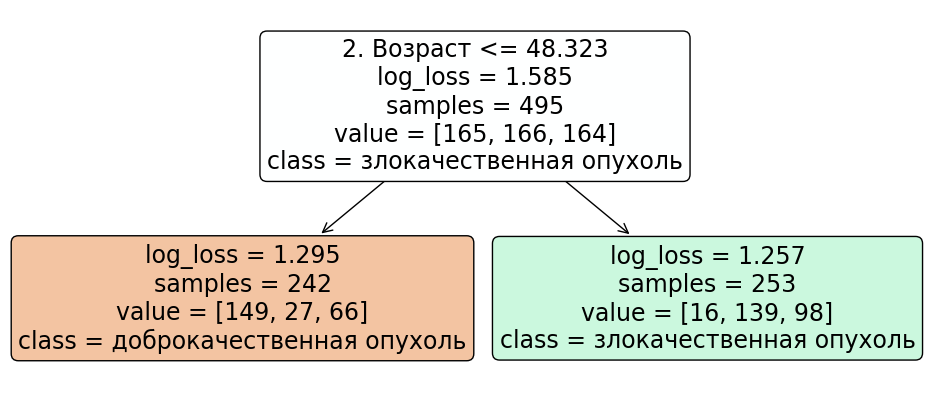

In [12]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_tree(
    model.named_steps['decision_tree'],
    feature_names=model.named_steps['preprocessing'].transform(X_train).columns,
    class_names=model.classes_,
    filled=True,
    rounded=True,
    ax=ax,
)
plt.show()

## Perfomance на X_train

[К навигации](#Навигация)

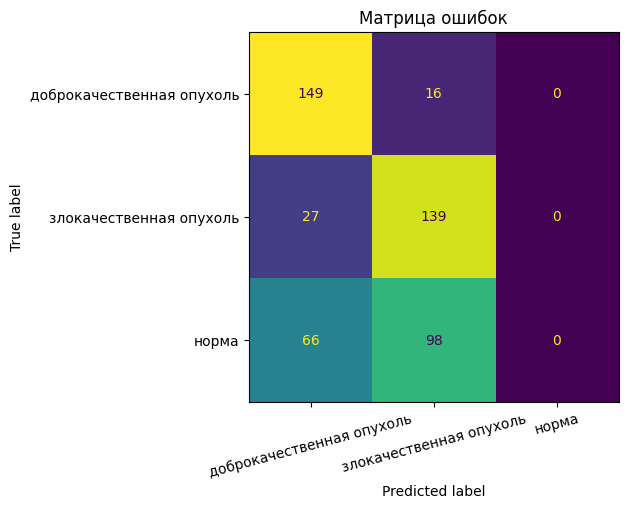

                           precision    recall  f1-score   support

доброкачественная опухоль       0.62      0.90      0.73       165
  злокачественная опухоль       0.55      0.84      0.66       166
                    норма       0.00      0.00      0.00       164

                 accuracy                           0.58       495
                macro avg       0.39      0.58      0.47       495
             weighted avg       0.39      0.58      0.47       495



E:\Projects\Breast-Cancer\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Projects\Breast-Cancer\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Projects\Breast-Cancer\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
my_multiclass_classification_report(model, X_train, y_train, cm_kw=dict(xticks_rotation=15))

## Perfomance на X_test

[К навигации](#Навигация)

In [76]:
rng = np.random.default_rng(i)
scores = []
for _ in range(BOOTSTRAP_SAMPLES):
    random_state = int(rng.random() * 1000)
    bootstrap_test_data = test_data.sample(frac=1, replace=True, random_state=random_state)
    bootstrap_X_test = bootstrap_test_data.drop(columns=src.constants.TARGET)
    bootstrap_y_test = bootstrap_test_data[src.constants.TARGET]
    y_pred = model.predict(bootstrap_X_test)
    score = accuracy_score(bootstrap_y_test, y_pred)
    scores.append(score)
scores = np.array(scores)
scores.mean()

0.5429999999999999

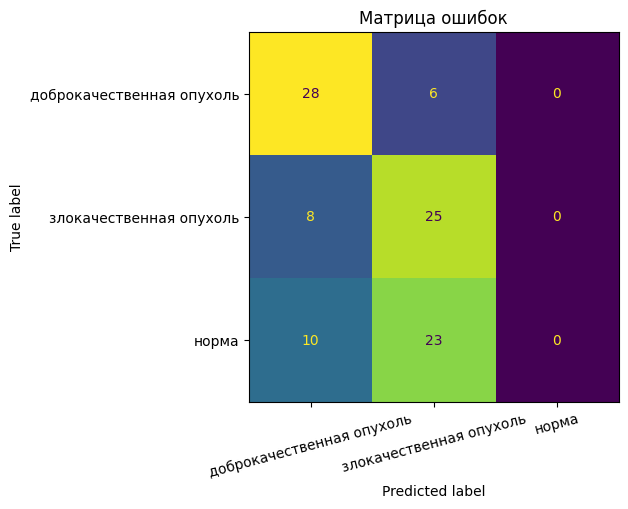

                           precision    recall  f1-score   support

доброкачественная опухоль       0.61      0.82      0.70        34
  злокачественная опухоль       0.46      0.76      0.57        33
                    норма       0.00      0.00      0.00        33

                 accuracy                           0.53       100
                macro avg       0.36      0.53      0.42       100
             weighted avg       0.36      0.53      0.43       100



E:\Projects\Breast-Cancer\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Projects\Breast-Cancer\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Projects\Breast-Cancer\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
my_multiclass_classification_report(model, X_test, y_test, cm_kw=dict(xticks_rotation=15))